In [1]:
using Revise, UKE, Optim, Plots, FileIO, JLD2, OffsetArrays, ProgressMeter

┌ Info: Precompiling UKE [384c50d4-0126-4b98-92c6-2fca2b7bede1]
└ @ Base loading.jl:1278
┌ Error: (compiled mode) evaluation error starting at /home/vavrines/.julia/packages/DistributionsAD/jDBqZ/src/reversediff.jl:26
│   mod = DistributionsAD.ReverseDiffX
│   ex = begin
    #= /home/vavrines/.julia/packages/DistributionsAD/jDBqZ/src/reversediff.jl:26 =#
    const RDBroadcasted{F, T} = Broadcasted{<:Any, <:Any, F, T}
end
│   exception = (ErrorException("invalid redefinition of constant RDBroadcasted"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f4e0b217def, Ptr{Nothing} @0x00007f4e0b2a7ebe, Ptr{Nothing} @0x00007f4e0b2a9898, Ptr{Nothing} @0x00007f4e0b2aa7a7, Base.InterpreterIP in top-level CodeInfo for DistributionsAD.ReverseDiffX at statement 15])
└ @ Revise /home/vavrines/.julia/packages/Revise/BqeJF/src/lowered.jl:85


In [259]:
case = "shock"
space = "1d2f1v"
nSpecies = 1
interpOrder = 1
limiter = "vanleer"
cfl = 0.7
maxTime = 250.0
x0 = -35.0
x1 = 35.0
nx = 80
pMeshType = "uniform"
nxg = 1
umin = -10.0
umax = 10.0
nu = 56
nug = 0
vmin = -10.0
vmax = 10.0
nv = 28
nvg = 0
wmin = -10.0
wmax = 10.0
nw = 28
nwg = 0
vMeshType = "rectangle"
knudsen = 1.0
mach = 1.2
prandtl = 0.6666667
inK = 2
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
nm = 5
tLen = 3
nh = 10

10

In [260]:
γ = heat_capacity_ratio(inK, 1)
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType)
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)
wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR = ib_rh(mach, γ, vSpace.u, inK)
ib = IB2F(wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR)
ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd())

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen)

0.0f0:0.027846409f0:0.055692818f0

In [261]:
ctr = OffsetArray{ControlVolume1D2F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx ÷ 2
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wL),
            Float32.(ks.ib.primL),
            Float32.(ks.ib.hL),
            Float32.(ks.ib.bL),
        )
    else
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wR),
            Float32.(ks.ib.primR),
            Float32.(ks.ib.hR),
            Float32.(ks.ib.bR),
        )
    end
end
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

In [297]:
sumRes = zeros(3)
@showprogress for iter = 1:2000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, sumRes, collision=:bgk)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


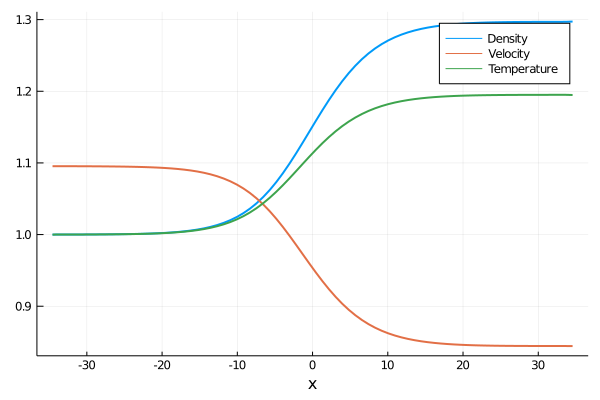

In [298]:
plot_line(ks, ctr)

In [266]:
sol = zeros(nx, 8)
for i in 1:nx
    sol[i, 1] = ctr[i].prim[1]
    sol[i, 2] = ctr[i].prim[2]
    sol[i, 3] = 1. / ctr[i].prim[3]
    sol[i, 4] = 0.5 * ctr[i].prim[1] / ctr[i].prim[3] # p
    sol[i, 5] = sum(@. ks.vSpace.weights * (ks.vSpace.u - ctr[i].prim[2])^2 * ctr[i].h) # Pxx
    sol[i, 6] = heat_flux(ctr[i].h, ctr[i].b, ctr[i].prim, ks.vSpace.u, ks.vSpace.weights) # q
    sol[i, 7] = ks.gas.μᵣ * (1. / ctr[i].prim[3])^ks.gas.ω # μ
    sol[i, 8] = 5 / 4 * sol[i, 7] # κ
end

In [267]:
Δ = zeros(nx, 3)
for i in 1:3
    Δ[:, i] .= central_diff(sol[:, i], ks.pSpace.x[1:nx])
end

In [268]:
appr = zeros(nx, 2)
for i in 1:nx
    appr[i, 1] = sol[i, 4]
    appr[i, 2] = -sol[i, 8] * Δ[i, 3]
end

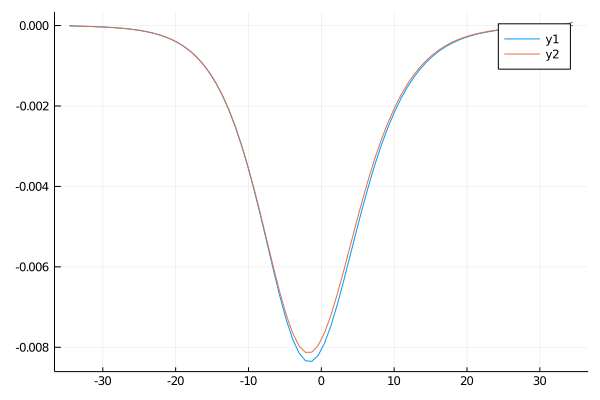

In [269]:
plot(ks.pSpace.x[1:nx], sol[:, 6])
plot!(ks.pSpace.x[1:nx], appr[:, 2])

In [270]:
X = Array{Float32}(undef, 6, nx)
for i in axes(X, 2)
    X[:, i] .= [sol[i, 1], sol[i, 3], sol[i, 7], Δ[i, 1], Δ[i, 2], Δ[i, 3]]
end

Yp = Array{Float32}(undef, 1, size(X, 2))
for i in axes(Yp, 2)
    Yp[1, i] = sol[i, 5]
end

Yq = Array{Float32}(undef, 1, size(X, 2))
for i in axes(Yq, 2)
    Yq[1, i] = sol[i, 6]
end

#X1 = Array{Float32}(undef, 2, nx)
#for i = 1:nx
#    X1[:, i] .= [sol[i, 7], Δ[i, 3]]
#end

#Y1 = Array{Float32}(undef, 1, size(X1, 2))
#for i in axes(Y1, 2)
#    Y1[1, i] = appr[i, 1]
#end

In [271]:
nn_p = FastChain(
    FastDense(6, 96, tanh),
    FastDense(96, 192, tanh),
    FastDense(192, 96, tanh),
    FastDense(96, 1, tanh),
)
nn_q = FastChain(
    FastDense(6, 96, tanh),
    FastDense(96, 192, tanh),
    FastDense(192, 96, tanh),
    FastDense(96, 1, tanh),
)

pp = initial_params(nn_p)
pq = initial_params(nn_q);

In [272]:
function loss_p(p)
    pred = nn_p(X, p)
    loss = sum(abs2, pred .- (Yp .- appr[:,1]')) # to learn deviation
    return loss
end

function loss_q(p)
    pred = nn_q(X, p)
    loss = sum(abs2, pred .- (Yq .- appr[:,2]')) # to learn deviation
    return loss
end

cb = function (p, l)
    #display(l)
    return false
end

#5 (generic function with 1 method)

In [273]:
rsp = DiffEqFlux.sciml_train(loss_p, pp, ADAM(), cb=Flux.throttle(cb, 1), maxiters=3000)

loss: 1.34e-06: 100%|█████████████████████████████████████████| Time: 0:01:08


 * Status: success

 * Candidate solution
    Final objective value:     1.336555e-06

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   68  (vs limit Inf)
    Iterations:    5000
    f(x) calls:    5000
    ∇f(x) calls:   5000


In [274]:
rsq = DiffEqFlux.sciml_train(loss_q, pq, ADAM(), cb=Flux.throttle(cb, 1), maxiters=3000)

loss: 4.26e-07: 100%|█████████████████████████████████████████| Time: 0:00:43


 * Status: success

 * Candidate solution
    Final objective value:     4.261605e-07

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   44  (vs limit Inf)
    Iterations:    3000
    f(x) calls:    3000
    ∇f(x) calls:   3000


In [41]:
rsp = DiffEqFlux.sciml_train(loss_p, rsp.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=2000)
rsq = DiffEqFlux.sciml_train(loss_q, rsq.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=2000)

loss: 1.42e-05: 100%|█████████████████████████████████████████| Time: 0:00:28
loss: 0.000309: 100%|█████████████████████████████████████████| Time: 0:00:28


 * Status: success

 * Candidate solution
    Final objective value:     3.088428e-04

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   29  (vs limit Inf)
    Iterations:    2000
    f(x) calls:    2000
    ∇f(x) calls:   2000


In [275]:
pred_p = nn_p(X, rsp.minimizer)
pred_q = nn_q(X, rsq.minimizer)

1×80 Array{Float32,2}:
 -1.08232f-5  -1.09229f-5  -1.09813f-5  …  -7.1941f-5  -6.30022f-5

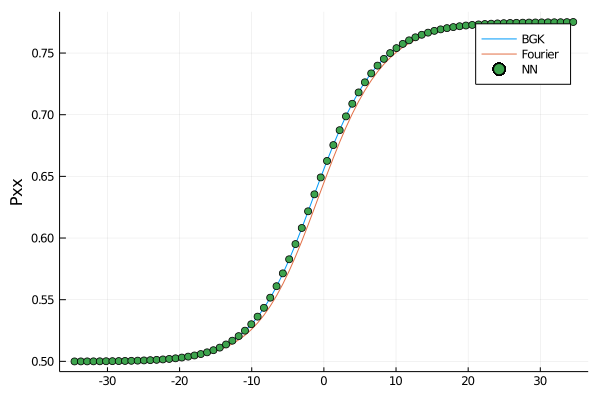

In [276]:
plot(ks.pSpace.x[1:nx], sol[:, 5], label="BGK", ylabel="Pxx")
plot!(ks.pSpace.x[1:nx], appr[:, 1], label="Fourier")
scatter!(ks.pSpace.x[1:nx], appr[:, 1] .+ pred_p[:], label="NN")

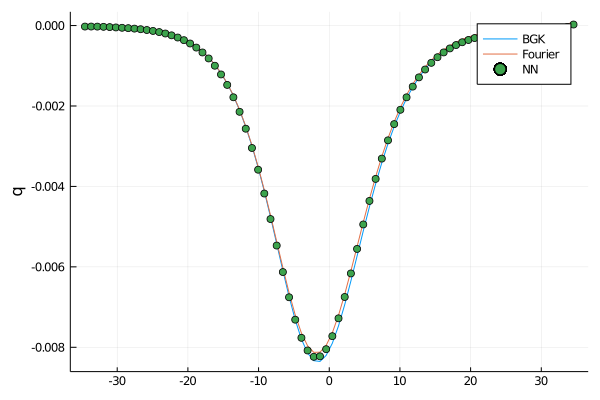

In [277]:
plot(ks.pSpace.x[1:nx], sol[:, 6], label="BGK", ylabel="q")
plot!(ks.pSpace.x[1:nx], appr[:, 2], label="Fourier")
scatter!(ks.pSpace.x[1:nx], appr[:, 2] .+ pred_q[:], label="NN")

In [299]:
function flux_closure!(
    fw::AbstractArray{<:AbstractFloat,1},
    wL::AbstractArray{<:AbstractFloat,1},
    wR::AbstractArray{<:AbstractFloat,1},
    γ::Real,
    inK::Real,
    μᵣ::Real,
    ω::Real,
    dt::Real,
    dx::Real,
    swL = zeros(eltype(fw), axes(wL))::AbstractArray{<:AbstractFloat,1},
    swR = zeros(eltype(fw), axes(wR))::AbstractArray{<:AbstractFloat,1},
    spL = zeros(eltype(fw), axes(wL))::AbstractArray{<:AbstractFloat,1},
    spR = zeros(eltype(fw), axes(wR))::AbstractArray{<:AbstractFloat,1},  
)

    primL = conserve_prim(wL, γ)
    primR = conserve_prim(wR, γ)

    Mu1, Mxi1, MuL1, MuR1 = gauss_moments(primL, inK)
    Mu2, Mxi2, MuL2, MuR2 = gauss_moments(primR, inK)

    w =
        primL[1] .* moments_conserve(MuL1, Mxi1, 0, 0) .+
        primR[1] .* moments_conserve(MuR2, Mxi2, 0, 0)
    prim = conserve_prim(w, γ)
    tau =
        vhs_collision_time(prim, μᵣ, ω) +
        2.0 * dt * abs(primL[1] / primL[end] - primR[1] / primR[end]) /
        (primL[1] / primL[end] + primR[1] / primR[end])

    faL = pdf_slope(primL, swL, inK)
    sw = -primL[1] .* moments_conserve_slope(faL, Mu1, Mxi1, 1)
    faTL = pdf_slope(primL, sw, inK)

    faR = pdf_slope(primR, swR, inK)
    sw = -primR[1] .* moments_conserve_slope(faR, Mu2, Mxi2, 1)
    faTR = pdf_slope(primR, sw, inK)

    Mu, Mxi, MuL, MuR = gauss_moments(prim, inK)
    sw0L = (w .- wL) ./ (0.5 * dx)
    sw0R = (wR .- w) ./ (0.5 * dx)
    gaL = pdf_slope(prim, sw0L, inK)
    gaR = pdf_slope(prim, sw0R, inK)
    sw =
        -prim[1] .* (
            moments_conserve_slope(gaL, MuL, Mxi, 1) .+
            moments_conserve_slope(gaR, MuR, Mxi, 1)
        )
    # ga = pdf_slope(prim, sw, inK)
    # sw = -prim[1] .* moments_conserve_slope(ga, Mu, Mxi, 1)
    gaT = pdf_slope(prim, sw, inK)

    # time-integration constants
    Mt = zeros(5)
    Mt[4] = tau * (1.0 - exp(-dt / tau))
    Mt[5] = -tau * dt * exp(-dt / tau) + tau * Mt[4]
    Mt[1] = dt - Mt[4]
    Mt[2] = -tau * Mt[1] + Mt[5]
    Mt[3] = 0.5 * dt^2 - tau * Mt[1]

    # flux related to central distribution
    Muv = moments_conserve(Mu, Mxi, 1, 0)
    MauL = moments_conserve_slope(gaL, MuL, Mxi, 2)
    MauR = moments_conserve_slope(gaR, MuR, Mxi, 2)
    # Mau = moments_conserve_slope(ga, MuR, Mxi, 2)
    MauT = moments_conserve_slope(gaT, Mu, Mxi, 1)

    fw .=
        Mt[1] .* prim[1] .* Muv .+ Mt[2] .* prim[1] .* (MauL .+ MauR) .+
        Mt[3] .* prim[1] .* MauT
    # fw .= Mt[1] .* prim[1] .* Muv .+ Mt[2] .* prim[1] .* Mau .+ Mt[3] .* prim[1] .* MauT

    # flux related to upwind distribution
    MuvL = moments_conserve(MuL1, Mxi1, 1, 0)
    MauL = moments_conserve_slope(faL, MuL1, Mxi1, 2)
    MauLT = moments_conserve_slope(faTL, MuL1, Mxi1, 1)

    MuvR = moments_conserve(MuR2, Mxi2, 1, 0)
    MauR = moments_conserve_slope(faR, MuR2, Mxi2, 2)
    MauRT = moments_conserve_slope(faTR, MuR2, Mxi2, 1)

    @. fw +=
        Mt[4] * primL[1] * MuvL - (Mt[5] + tau * Mt[4]) * primL[1] * MauL -
        tau * Mt[4] * primL[1] * MauLT + Mt[4] * primR[1] * MuvR -
        (Mt[5] + tau * Mt[4]) * primR[1] * MauR - tau * Mt[4] * primR[1] * MauRT
    # @. fw += Mt[4] * primL[1] * MuvL + Mt[4] * primR[1] * MuvR

    #--- NN ---#
    κ = tau * 0.5 * prim[1] / prim[3] * 5/4
    
    ΔL = @. (prim - primL) / (0.5 * dx)
    ΔL[3] = (1/prim[3] - 1/primL[3]) / (0.5 * dx)
    ΔR = @. (primR - prim) / (0.5 * dx)
    ΔR[3] = (1/primR[3] - 1/prim[3]) / (0.5 * dx)
    
    Δ = minmod.(ΔL, ΔR)
    
    input = Array{Float32}(undef, 6)
    input .= [prim[1], prim[3], κ, Δ[1], Δ[2], Δ[3]]
    
    p_plus = nn_p(input, rsp.minimizer)
    q_plus = nn_q(input, rsq.minimizer)
    
    fw[2] += p_plus[1] * dt
    fw[3] += q_plus[1] * dt + p_plus[1] * prim[2] * dt
    
end

flux_closure! (generic function with 5 methods)

In [322]:
sumRes = zeros(3)
sumAvg = zeros(3)

@showprogress for iter = 1:100
    #Kinetic.evolve!(ks, ctr, face, dt)

    for i = 1:ks.pSpace.nx+1
        flux_closure!(face[i].fw, ctr[i-1].w, ctr[i].w, ks.gas.γ, ks.gas.K, ks.gas.μᵣ, ks.gas.ω, dt, ctr[i-1].dx)
        #flux_gks!(face[i].fw, ctr[i-1].w, ctr[i].w, ks.gas.γ, ks.gas.K, ks.gas.μᵣ, ks.gas.ω, dt, ctr[i-1].dx)
        
        #flux_gks!(face[i].fw, face[i].fh, face[i].fb, ctr[i-1].w, ctr[i-1].h, ctr[i-1].b, 
        #    ctr[i].w, ctr[i].h, ctr[i].b, ks.vSpace.u, ks.vSpace.weights, 
        #    ks.gas.K, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, dt, ctr[i-1].dx/2, ctr[i].dx/2)
    end
    
    #Kinetic.update!(ks, ctr, face, dt, sumRes, collision=:bgk)
    #
    for i = 2:ks.pSpace.nx-1
        Kinetic.step!(
            face[i].fw,
            ctr[i].w,
            ctr[i].prim,
            face[i+1].fw,
            ks.gas.γ,
            ctr[i].dx,
            sumRes,
            sumAvg,
        )
    end
    #
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


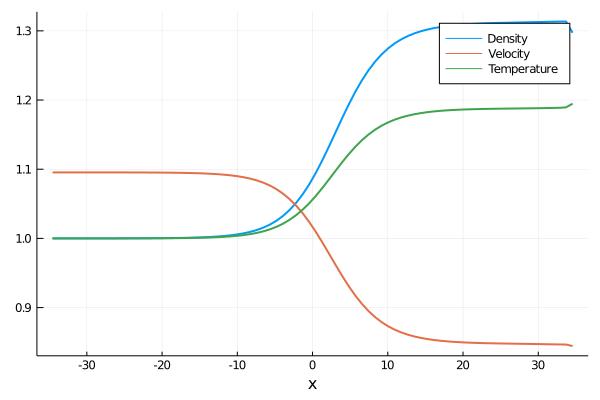

In [323]:
plot_line(ks, ctr)